# Point Cloud Classification with PointNet

In [1]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available:  1


In [5]:
# if file is local only
# tf.keras.utils.get_file(fname=None, origin=f'file://absolute/path/to/file.zip', extract=True)

## Download the Dataset

In [6]:
from pathlib import Path
Path(".\\datasets").mkdir(parents=True, exist_ok=True)
import shutil
if os.path.isfile((os.getcwd()+"\\datasets\\"+"ModelNet10.zip")):
    DATA_DIR = os.getcwd()+"\\datasets\\"
else:
    DATA_DIR = tf.keras.utils.get_file(
        os.getcwd()+"\\datasets\\"+"ModelNet10.zip",
        "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
        extract=True,
    )
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")
# it always extracts to user dir :-(
if not os.path.exists(DATA_DIR):
    shutil.move(os.path.expanduser("~")+"\\.keras\\datasets\\"+"ModelNet10", os.getcwd()+"\\datasets\\")

# Existence of README confuses the load of the data
Path(DATA_DIR + "\\" + "README.txt").unlink(missing_ok=True)


## Visualize a Mesh from the Dataset

In [7]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

## Sample a Mesh and Show Result

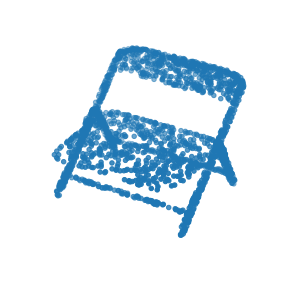

In [8]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

## Function to Parse Data
- Each mesh is loaded and sampled into a point cloud and is returned as a numpy array

In [9]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

## Parse the Dataset and Process each Class

## Augenmentation for Train Dataset

In [10]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32


train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class: bathtub
processing class: bed
processing class: chair
processing class: desk
processing class: dresser
processing class: monitor
processing class: night_stand
processing class: sofa
processing class: table
processing class: toilet


In [11]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

## Functions to Build the Model

In [12]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [13]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

## Function to create T-net Layers

In [14]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

## Create the Convolutional Neural Network

In [15]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

## Compile and Train the Model

In [16]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
125/125 [==============================] - 58s 395ms/step - loss: 3.5556 - sparse_categorical_accuracy: 0.2699 - val_loss: 38084285628579577856.0000 - val_sparse_categorical_accuracy: 0.1982
Epoch 2/20
125/125 [==============================] - 49s 388ms/step - loss: 3.1123 - sparse_categorical_accuracy: 0.3651 - val_loss: 6397313024.0000 - val_sparse_categorical_accuracy: 0.2863
Epoch 3/20
125/125 [==============================] - 49s 391ms/step - loss: 2.8975 - sparse_categorical_accuracy: 0.4257 - val_loss: 2006578119049216.0000 - val_sparse_categorical_accuracy: 0.4824
Epoch 4/20
125/125 [==============================] - 49s 392ms/step - loss: 2.6463 - sparse_categorical_accuracy: 0.5029 - val_loss: 103331700736.0000 - val_sparse_categorical_accuracy: 0.3722
Epoch 5/20
125/125 [==============================] - 49s 394ms/step - loss: 2.5124 - sparse_categorical_accuracy: 0.5517 - val_loss: 202401256570880.0000 - val_sparse_categorical_accuracy: 0.5452
Epoch 6/20
125/12

In [17]:
from pathlib import Path
Path(".\\models").mkdir(parents=True, exist_ok=True)

model.save_weights(".\\models\\pointnetweight20.model")

In [18]:
mesh = trimesh.load(os.path.join(".\\", "Prep_stuhl10.obj"))
mesh.show()


## Visualize The Predictions

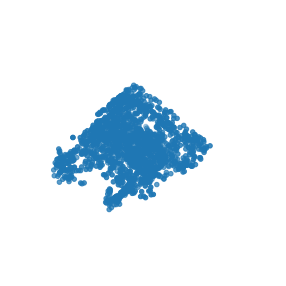

In [19]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [20]:
data_points=[]
data_labels=[]
data_labels.append("0")
data_points.append(points)
data_points_check = tf.data.Dataset.from_tensor_slices((data_points, data_labels))
data_points_check = data_points_check.shuffle(len(data_points_check)).batch(BATCH_SIZE)

In [21]:
preds = model.predict(data_points_check)
preds = tf.math.argmax(preds, -1)

In [22]:
CLASS_MAP[preds[0].numpy()]

'C:\\Dev\\Projects\\Notebooks\\pointcloud\\NeuralNetworks\\datasets\\ModelNet10\\chair'

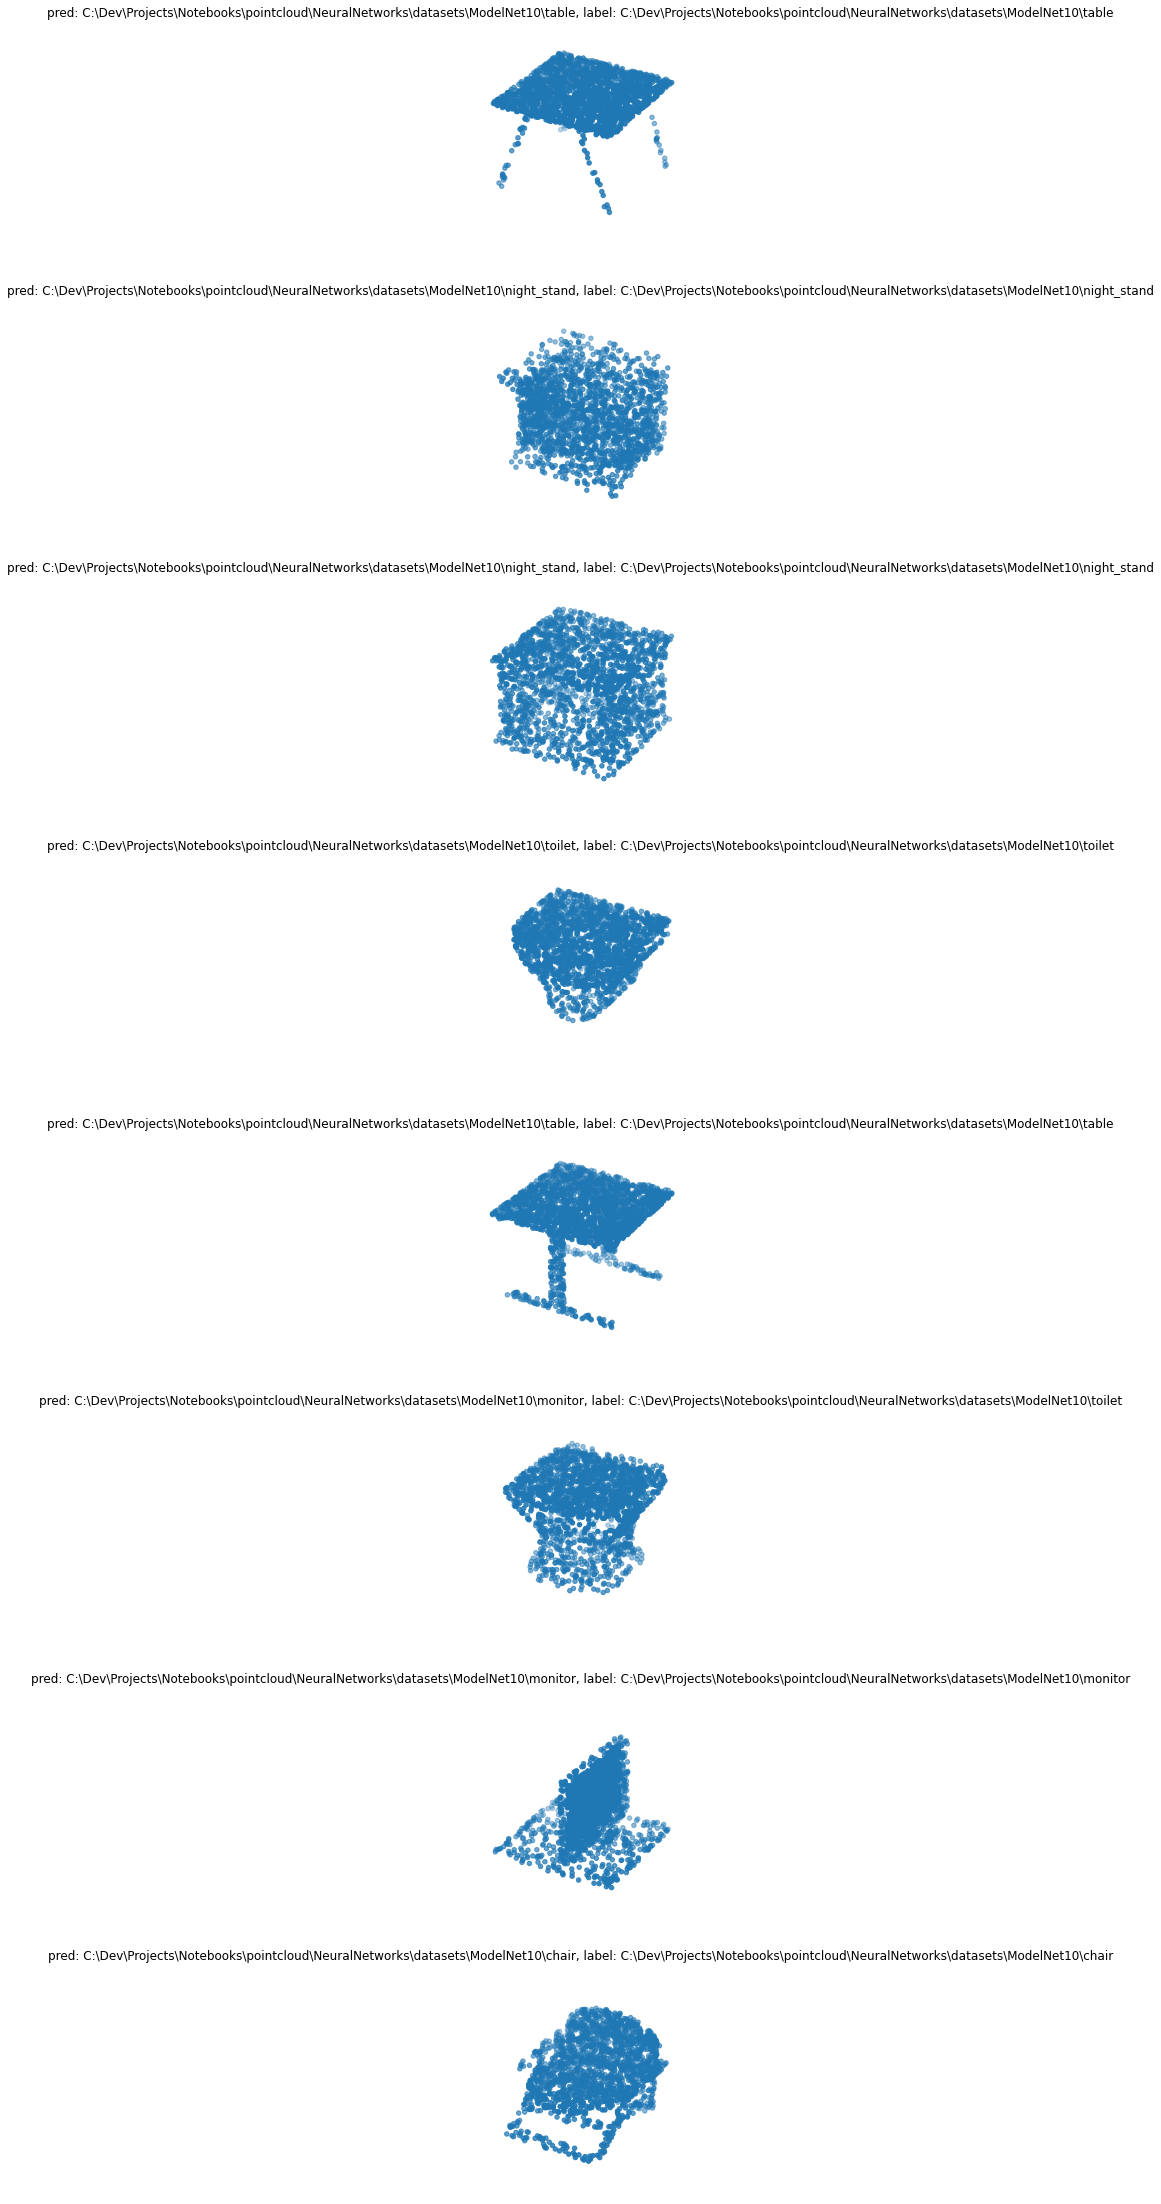

In [30]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(60, 40))
for i in range(8):
    ax = fig.add_subplot(8, 1, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [ ]:
CL